# <span style="font-family:cursive;text-align:center">Game of Thrones Text Generation : </span>

# <span style="font-family:cursive;text-align:center">⬇️ Importing Libraries</span>

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

import re
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Input,Lambda  
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse,MeanSquaredError, CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, TextDataset, LineByLineTextDataset, set_seed
from datasets import load_dataset

import pickle

# <span style="font-family:cursive;text-align:center">⬇️ Importing Data</span>

In [134]:
# Read the .txt file into a string
with open('C:/Users/santh/Downloads/got1.txt', 'r', encoding='utf-8') as file:
    data = file.read()

In [135]:
data[:500]

'"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are \ndead." \n"Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. \nGared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. \n"Dead is dead," he said. "We have no business with the dead." \n"Are they dead?" Royce asked softly. "What proof have we?" \n"Will saw them," Gared said. "If he says they are dead, that\'s proof enough fo'

# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

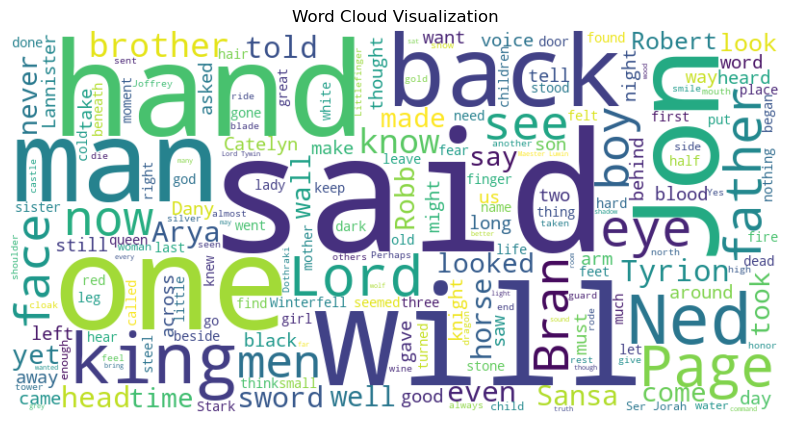

In [136]:
# Word Cloud Visualization:

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(data)

# Plot the word cloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud Visualization')
plt.show()

In [137]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize (split the text into words)
    tokens = text.split()
    
    return tokens

# Tokenize the text data
tokens = preprocess_text(data)

In [138]:
tokens[:10]

['we',
 'should',
 'start',
 'back',
 'gared',
 'urged',
 'as',
 'the',
 'woods',
 'began']

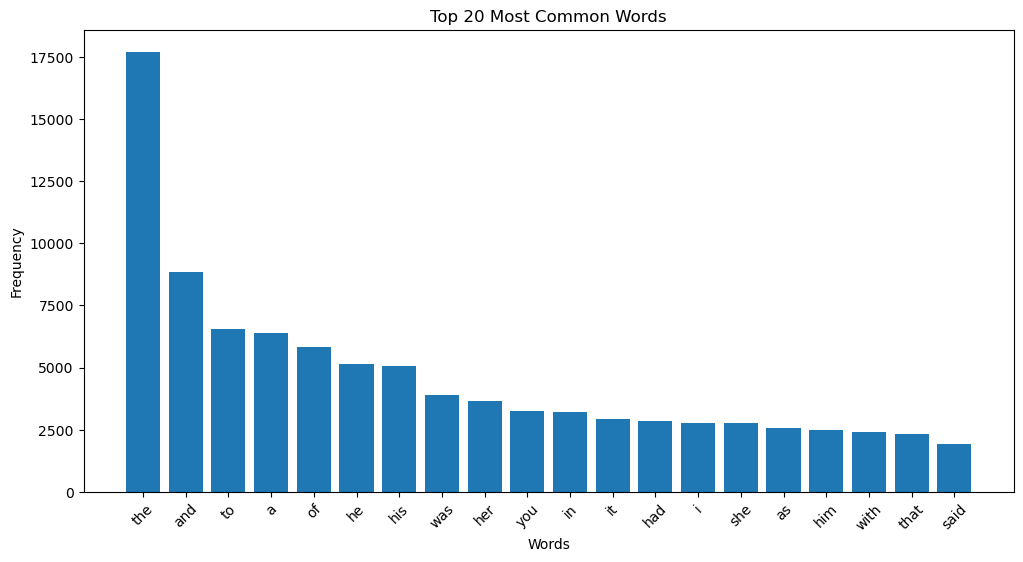

In [139]:
# Calculate word frequencies
word_counts = Counter(tokens)

# Plot a histogram of the top N most frequent words
top_N = 20
most_common_words = word_counts.most_common(top_N)

words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Common Words'.format(top_N))
plt.xticks(rotation=45)
plt.show()

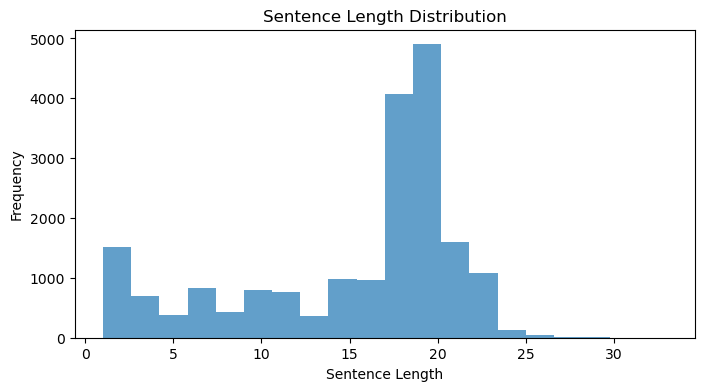

In [140]:
# Calculate sentence lengths

sentence_lengths = [len(sentence.split()) for sentence in data.split('\n') if sentence.strip()]

# Plot a histogram of sentence lengths
plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=20, alpha=0.7)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()

<BarContainer object of 2 artists>

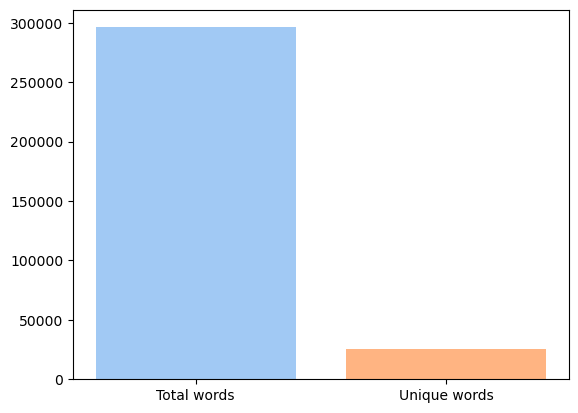

In [141]:
# Total words vs Unique words :

plt.bar(x = ["Total words", "Unique words"], 
        height=[len(data.split()), len(set(data.split()))], 
        color=sns.color_palette('pastel'))

In [142]:
print('Total Tokens: %d' % len(data.split()))
print('Unique Tokens: %d' % len(set(data.split())))

Total Tokens: 296164
Unique Tokens: 25841


**Insights :**

- There is high no of Stop Words in the data resulting in difference between total & Unique Words

# <span style="font-family:cursive;text-align:center">🔨 Corpus Preparation</span>

In [143]:
#Function to Clean the Text data :

def clean_text(text):
    sample = text
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample)
    sample = [word for word in sample.split() if word.isalpha()]
    sample = [word.lower() for word in sample]
    sample = " ".join(sample)
    
    return sample

In [144]:
cleaned_data = clean_text(data)

In [145]:
cleaned_data[:100]

'we should start back gared urged as the woods began to grow dark around them the wildlings are dead '

In [146]:
# Preparing sequences of text data :

sequences_doc = []
seq_len = 50
l = seq_len + 1
tokens = [w for w in cleaned_data.split()]

for i in range(l, len(tokens)):
    seq = tokens[i-l:i]

    line = ' '.join(seq)
    sequences_doc.append(line)
    
# print the length of sequences   
len(sequences_doc)

292813

In [147]:
sequences_doc[0]

'we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a smile gared did not rise to the bait he was an old man past fifty and he'

In [148]:
sequences_doc[:15]

['we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a smile gared did not rise to the bait he was an old man past fifty and he',
 'should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a smile gared did not rise to the bait he was an old man past fifty and he had',
 'start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a smile gared did not rise to the bait he was an old man past fifty and he had seen',
 'back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a smile gared did not rise to the bait he was an old man past fifty and he had seen the',
 'gared

In [149]:
with open('C:/Users/santh/Downloads/seq_doc.txt', 'w') as f:
    f.writelines(sequences_doc)

In [150]:
# text tokenization and vocabulary preparation :

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences_doc)
sequences = tokenizer.texts_to_sequences(sequences_doc)

vocab_size = len(tokenizer.word_index) + 1
print(f'vocab_size = {vocab_size}')

vocab_size = 11922


In [151]:
# convert sequences into tokens
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

# convert y in categorical format 
y = to_categorical(y, num_classes=vocab_size)

# length of each sequences 
seq_length = X.shape[1]

In [152]:
# lets' check the length of the input_sequences
len(X)

292813

# <span style="font-family:cursive;text-align:center">⚙️ Modelling :</span>

## <span style="font-family:cursive;text-align:center">🔪 Model 1 with LSTM: :</span>

In [29]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 50)            596100    
                                                                 
 lstm_10 (LSTM)              (None, 50, 100)           60400     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 11922)             1204122   
                                                                 
Total params: 1,951,122
Trainable params: 1,951,122
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model (adjust epochs and batch_size as needed)
model.fit(X, y, epochs=10, batch_size=128)

Epoch 1/10
2288/2288 [==============================] - 547s 236ms/step - loss: 6.4894 - accuracy: 0.0676
Epoch 2/10
2288/2288 [==============================] - 324s 142ms/step - loss: 5.9718 - accuracy: 0.0938
Epoch 3/10
2288/2288 [==============================] - 330s 144ms/step - loss: 5.7013 - accuracy: 0.1114
Epoch 4/10
2288/2288 [==============================] - 331s 145ms/step - loss: 5.5031 - accuracy: 0.1202
Epoch 5/10
2288/2288 [==============================] - 334s 146ms/step - loss: 5.3532 - accuracy: 0.1263
Epoch 6/10
2288/2288 [==============================] - 340s 148ms/step - loss: 5.2323 - accuracy: 0.1316
Epoch 7/10
2288/2288 [==============================] - 340s 149ms/step - loss: 5.1314 - accuracy: 0.1354
Epoch 8/10
2288/2288 [==============================] - 348s 152ms/step - loss: 5.0451 - accuracy: 0.1387
Epoch 9/10
2288/2288 [==============================] - 352s 154ms/step - loss: 4.9673 - accuracy: 0.1427
Epoch 10/10
2288/2288 [=======================

In [31]:
model.save('text_gen_model.h5')
# save the tokenizer
pickle.dump(tokenizer, open('tokenizer_text_gen.pkl', 'wb'))

In [32]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
    # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict(encoded, verbose=0)
        yhat = np.argmax(yhat,axis=1)
        print(yhat)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [34]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 30)

he paid double for a maiden knowing it would be my first time after jaime had made his confession to drive home the lesson lord tywin brought my wife in and gave her to his guards they paid her fair enough a silver for each man how many whores command that

[1]
[75]
[20]
[1]
[75]
[8]
[4]
[235]
[3]
[36]
[4]
[54]
[11]
[1]
[269]
[5]
[1]
[295]
[493]
[6]
[20]
[1]
[75]
[8]
[4]
[235]
[3]
[36]
[4]
[54]


'the king said the king was a moment to be a man in the north of the seven kingdoms he said the king was a moment to be a man'

In [157]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 25)

turnkey was twenty stone of gross stupidity with brown rotting teeth and small dark eyes the left side of his face was slick with scar where an axe had cut off his ear and part of his cheek he was as predictable as he was ugly but tyrion was hungry he

[40]
[39]
[38]
[37]
[36]
[35]
[34]
[33]
[32]
[31]
[30]
[29]
[28]
[27]
[26]
[25]
[24]
[23]
[22]
[21]
[20]
[19]
[18]
[17]
[16]


'ser when your all be would were have them from no lord my is they but on at for not said that with him as'

In [158]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 40)

said jorah aside what do you make of his report daenerys targaryen has wed some dothraki horselord what of it shall we send her a wedding gift the king frowned a knife perhaps a good sharp one and a bold man to wield it ned did not feign surprise roberts hatred

[46]
[45]
[44]
[43]
[42]
[41]
[40]
[39]
[38]
[37]
[36]
[35]
[34]
[33]
[32]
[31]
[30]
[29]
[28]
[27]
[26]
[25]
[24]
[23]
[22]
[21]
[20]
[19]
[18]
[17]
[16]
[15]
[14]
[13]
[12]
[11]
[10]
[9]
[8]
[7]


'one could so will if me ser when your all be would were have them from no lord my is they but on at for not said that with him as she i had it in you her was his'